# Statistics Project
# Nadav Vazana & Doron Battino

#  Part I

# Section I: Choosing a Dataset

For our project we have decided to use the FIFA dataset. This dataset contains data taken from the game FIFA 19. In the game, you are able to construct a soccer team from various real life players that are represented in the game. This dataset contains the attributes and stats used to represent these players in the game.

The dataset can be found at https://www.kaggle.com/datasets/devansodariya/football-fifa-2019-dataset.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import t, norm
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

FILE_PATH = "/kaggle/input/football-fifa-2019-dataset/FIFA-2019.csv"
fifa = pd.read_csv(FILE_PATH)

Of the 89 columns present in the dataset, we have decided to use the following:
*      ID - A unique ID for each player
*      Overall - An overall rating of the player based on his attributes and international recognition. Int that runs from 0                to 99, the higher the score, the better the player.
*      Preferred Foot - The preferred foot of the player. String that receives "Left" or "Right".
*      Weak Foot - Measures the ability of a player to shoot with one foot as he does with his preferred foot. Int that runs                  from 1 to 5, higher value is better.
*      Agility - Measures how agile the player is while moving or turning. Int that runs from 0 to 99, higher score is                      better.
*      Stamina - Determines the rate at which a player will tire during a game. Int that runs from 0 to 99, higher score is                better (the player will tire at a slower rate).



In [2]:
COLUMNS = ['ID', 'Overall', 'Preferred Foot', 'Weak Foot', 'Agility', "Stamina"]
fifa = fifa[COLUMNS]

After removing rows that contain null values we are left with:

In [3]:
fifa = fifa.dropna()
len(fifa)

18159

# Section II: Initial Statistical Analysis

In [4]:
fifa.describe()

,ID,Overall,Weak Foot,Agility,Stamina
count,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,214279.590286,66.249904,2.947299,63.503607,63.219946
std,29968.461880,6.914613,0.660456,14.766049,15.894741
min,16.000000,46.000000,1.000000,14.000000,12.000000
25%,200300.000000,62.000000,3.000000,55.000000,56.000000
50%,221743.000000,66.000000,3.000000,66.000000,66.000000
75%,236508.500000,71.000000,3.000000,74.000000,74.000000
max,246620.000000,94.000000,5.000000,96.000000,96.000000


From initial observation, it seems like Overall, Agility and Stamina have a similar distribution since their quantiles are nearly identical. However, it is worth noting that Overall has significantly less variance than Agility and Stamina.

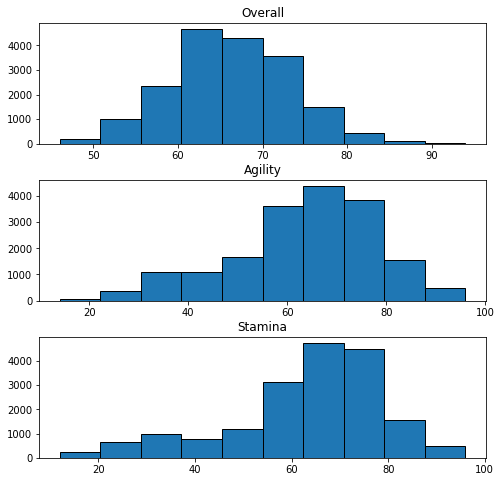

In [5]:
fifa.hist(['Overall', 'Agility', 'Stamina'], layout=(3,1), figsize=(8,8.), grid=False, ec='black');

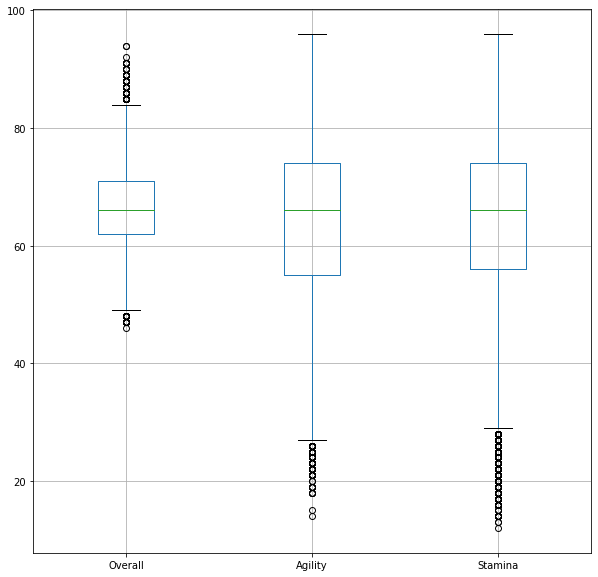

In [6]:
fifa.boxplot(['Overall', 'Agility', 'Stamina'], figsize=(10,10));

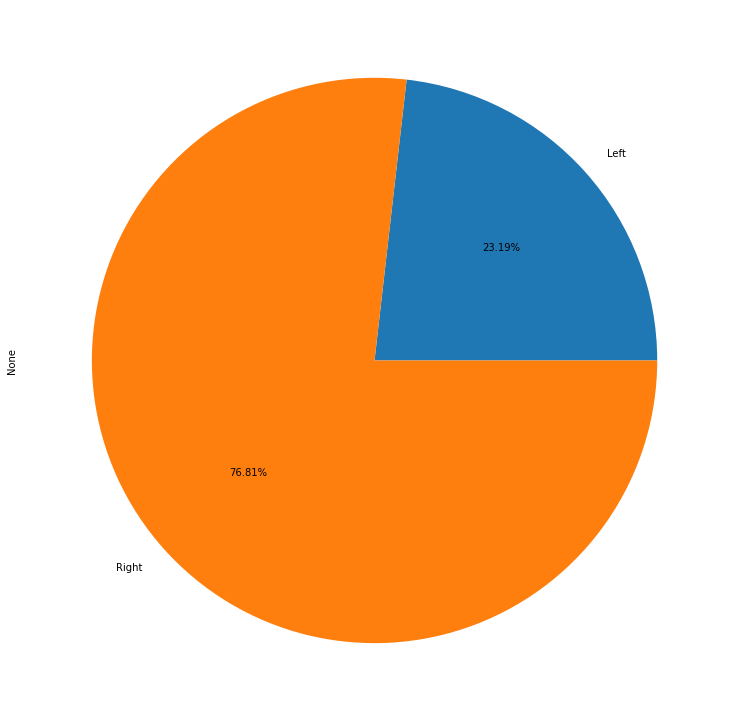

In [7]:
fifa.groupby("Preferred Foot").size().plot.pie(autopct="%.2f%%", figsize=(13,13));

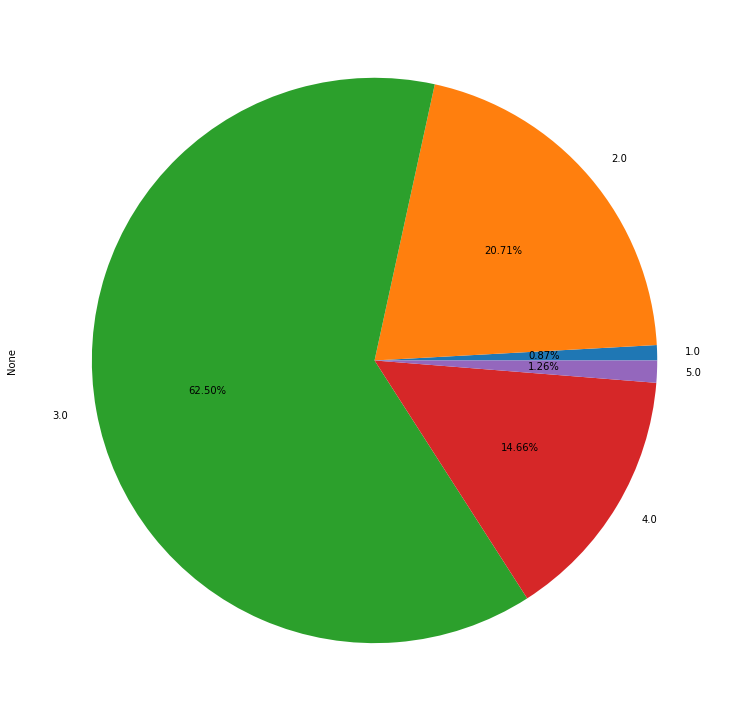

In [8]:
fifa.groupby("Weak Foot").size().plot.pie(autopct="%.2f%%", figsize=(13,13));

# Section III: Research Questions

Here are some examples for research questions we can pursue with our data:
1.     Does a higher Agility rating lead to a higher Overall rating?
1.     Does a higher Overall rating increases the chance that Preferred Foot is "Left"?
1.     Does the Stamina rating change between different ratings of Weak Foot?

# Part II

# Section I

In this section we will estimate the expected value of Overall between different categories of Preferred Foot.

In [9]:
data = fifa.filter(items=['Preferred Foot', 'Overall'])
data.groupby('Preferred Foot').mean()

,Overall
Preferred Foot,
Left,66.801472
Right,66.083381


We will build a confidence interval with a strength of 0.95:

In [10]:
data_right = data.loc[data['Preferred Foot'] == 'Right']['Overall']
data_left = data.loc[data['Preferred Foot'] == 'Left']['Overall']
mean_left = data_left.mean()
mean_right = data_right.mean()
print('Confidence interval for right:')
print([mean_right - 2*data_right.std()/(len(data_right)**(1/2)), mean_right + 2*data_right.std()/(len(data_right)**(1/2))])
print('Confidence interval for left:')
print([mean_left - 2*data_left.std()/(len(data_left)**(1/2)), mean_left + 2*data_left.std()/(len(data_left)**(1/2))])

Confidence interval for right:
[65.96465883149025, 66.20210342833195]
Confidence interval for left:
[66.59937767073195, 67.00356699799282]


Our intervals don't overlap, implying that the expected value of Overall is different between those categories of Preferred Foot.

# Section II - Tests

$$ H_0: \mu_{Left} - \mu_{Right} = 0 $$
$$ H_1: \mu_{Left} - \mu_{Right} \neq 0 $$

First, we will check if our data appears to follow a normal distribution:

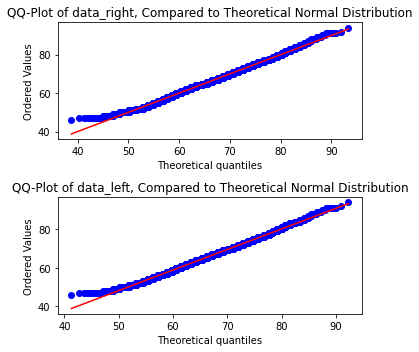

In [11]:
import numpy as np
from scipy.stats import norm
from scipy.stats import probplot
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, figsize=(5,5))
mu_right, std_right = norm.fit(data_right) 
mu_left, std_left = norm.fit(data_left)
probplot(data_right, sparams=(mu_right, std_right), plot=axs[0])
axs[0].set_title('QQ-Plot of data_right, Compared to Theoretical Normal Distribution')
probplot(data_right, sparams=(mu_left, std_left), plot=axs[1])
axs[1].set_title('QQ-Plot of data_left, Compared to Theoretical Normal Distribution')
plt.tight_layout()
plt.show()

Based on the plots, it seems very likely that the data is distributed normally. Moreover, it seems like the variance is equal between the different categories of Preferred Foot.

**t test (size 0.05):**

In [12]:
n_right = len(data_right)
n_left = len(data_left)
sp = (((n_right-1)*data_right.std()**2 + (n_left - 1)*data_left.std()**2)/(n_right + n_left - 2))**(1/2)
tn = (mean_right - mean_left) / (sp * (1/n_right + 1/n_left)**(1/2))

In [13]:
from scipy.stats import t
rej = t.ppf(0.975, n_right + n_left - 2)
if abs(tn) > rej:
    print(False)
else:
    print(True)

False


According to the t test we should reject $H_0$

**Wald test (size 0.05):**

In [14]:
from scipy.stats import norm
rej = norm.ppf(0.975)
if abs(tn) > rej:
    print(False)
else:
    print(True)

False


According to the Wald test we should reject $H_0$

We will calculate the pvalues for both tests:

In [15]:
pvalue_t = (1 - t.cdf(abs(tn), n_right + n_left - 2))*2
pvalue_Wald = (1 - norm.cdf(abs(tn)))*2
print('t pvalue:', pvalue_t)
print('Wald pvalue:', pvalue_Wald)

t pvalue: 3.444411422748317e-09
Wald pvalue: 3.3838232216254482e-09


We have received similiar results for the Wald test and the t test. That fits our expectations since the t distribution converges to standrad normal distribution as the degrees of freedom approach infinity. Essentially, thanks to the large sample size, both tests are almost exactly equal.

**Likelihood-ratio test (size 0.05)**

We will assume that both data_right and data_left are distributed normally with the same variance. After calculating we recieved the following estimators:

Under $H_0$:

$ \mu_{1} = \mu_{2} = \mu_0 $

$\hat{\mu_0} = \frac{\sum_{i=1}^{n} X_i + \sum_{i=1}^{m} Y_i}{m + n}$

$\hat{\sigma}^2 = \frac{\sum_{i=1}^{n} (X_i - \hat{\mu_0})^2 + \sum_{i=1}^{m} (Y_i - \hat{\mu_0})^2}{n + m}$

Otherwise:

$\hat{\mu_1} = \bar{X_n}$

$\hat{\mu_2} = \bar{Y_m}$

$\hat{\sigma}^2 = \frac{\sum_{i=1}^{n} (X_i - \hat{\mu_1})^2 + \sum_{i=1}^{m} (Y_i - \hat{\mu_2})^2}{n + m}$

In [16]:
import numpy as np
from scipy.stats import chi2
mu_0 = data['Overall'].mean()
std_0 = data['Overall'].std(ddof=0)
mu_1_left = mean_left

mu_1_right = mean_right
print(mu_1_right)
std_1 = (data_right.std(ddof=-n_left)**2 + data_left.std(ddof=-n_right)**2)**(1/2)
l_1 = np.sum(np.log(norm.pdf(data_left, mu_1_left, std_1))) + np.sum(np.log(norm.pdf(data_right, mu_1_right, std_1)))
l_0 = np.sum(np.log(norm.pdf(data['Overall'], mu_0, std_0)))
T = 2*(l_1 - l_0)
if T > chi2.ppf(0.95, 1):
    print(False)
else:
    print(True)

66.0833811299111
False


According to a Likelihood-ratio test of size 0.05 we should reject $H_0$

The pvalue for this test is:

In [17]:
print(1 - chi2.cdf(T, 1))

3.4359174394538172e-09


Overall, the tests produced similar results. According to the tests we should reject $H_0$. Every test had a pvalue of about 3.4e-09.

# Section III - Testing Different Sample Sizes

In this section, we will check the effects of sample size on the length of the confidence interval and on the result of the Wald test.

We will check sample sizes 30, 50 ,100, 500:

In [18]:
samples = [data.sample(30, random_state=0), data.sample(50, random_state=1), data.sample(100, random_state=2), data.sample(500, random_state=3)]

First we will calculate confidence intervals for the expected value:

In [19]:
for data, i in zip(samples, [30,50,100,500]):
    print('size', i)
    data_right = data.loc[data['Preferred Foot'] == 'Right']['Overall']
    data_left = data.loc[data['Preferred Foot'] == 'Left']['Overall']
    print('Confidence interval for right:')
    print([data_right.mean() - 2*data_right.std()/(len(data_right)**(1/2)), data_right.mean() + 2*data_right.std()/(len(data_right)**(1/2))])
    print('Confidence interval for left:')
    print([data_left.mean() - 2*data_left.std()/(len(data_left)**(1/2)), data_left.mean() + 2*data_left.std()/(len(data_left)**(1/2))])
    print()

size 30
Confidence interval for right:
[62.022814212202164, 67.72718578779784]
Confidence interval for left:
[63.67950620106143, 72.32049379893857]

size 50
Confidence interval for right:
[62.45628395883981, 66.87704937449354]
Confidence interval for left:
[66.5217739794083, 71.7282260205917]

size 100
Confidence interval for right:
[64.41827438871866, 67.46267799223372]
Confidence interval for left:
[64.84692112155533, 73.52807887844467]

size 500
Confidence interval for right:
[66.2585103171271, 67.7414896828729]
Confidence interval for left:
[66.26972363417228, 68.92407481544014]



All confidence intervals are longer than the confidence interval we have calculated in Section I. Also, while the confidence interval for right improves as we add more data, the confidence interval for left only significantly improves at size 500. This probably happens because left is under represented in our data.

Wald tests:

In [20]:
for data, i in zip(samples, [30, 50, 100,500]):
    print('size', i)
    data_right = data.loc[data['Preferred Foot'] == 'Right']['Overall']
    data_left = data.loc[data['Preferred Foot'] == 'Left']['Overall']
    n_right = len(data_right)
    n_left = len(data_left)
    sp = (((n_right-1)*data_right.std()**2 + (n_left - 1)*data_left.std()**2)/(n_right + n_left - 2))**(1/2)
    tn = (data_right.mean() - data_left.mean()) / (sp * (1/n_right + 1/n_left)**(1/2))
    rej = norm.ppf(0.975)
    if abs(tn) > rej:
        print(False)
    else:
        print(True)
    pvalue_Wald = (1 - norm.cdf(abs(tn)))*2
    print('Wald pvalue:', pvalue_Wald)
    print()

size 30
True
Wald pvalue: 0.3079375453093691

size 50
True
Wald pvalue: 0.08766881916344538

size 100
True
Wald pvalue: 0.10120536121710488

size 500
True
Wald pvalue: 0.4202079143157551



Unlike the tests we performed in Section II, All Wald tests maintain $H_0$. We think that the means are different but are very close to each other. As such, we need a big sample size to confidently attribute this difference to different means.

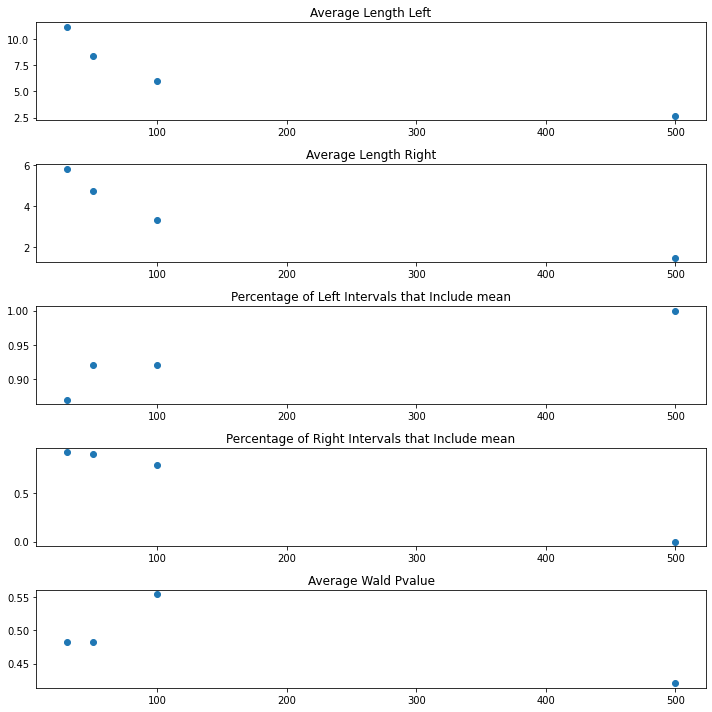

In [21]:
info = {n : {'avg_len_left': 0, 'avg_len_right':0, 'percentage_left': 0, 'percentage_right':0, 'pvalue':0} for n in [30, 50, 100, 500]}
for i in range(100):
    samples = [data.sample(30), data.sample(50), data.sample(100), data.sample(500)]
    while len(samples[0].loc[samples[0]['Preferred Foot'] == 'Left']) == 0:
        samples[0] = data.sample(30)
    for sample, i in zip(samples, [30,50,100,500]):
        data_right = sample.loc[sample['Preferred Foot'] == 'Right']['Overall']
        data_left = sample.loc[sample['Preferred Foot'] == 'Left']['Overall']
        n_right = len(data_right)
        n_left = len(data_left)
        sp = (((n_right-1)*data_right.std()**2 + (n_left - 1)*data_left.std()**2)/(n_right + n_left - 2))**(1/2)
        tn = (data_right.mean() - data_left.mean()) / (sp * (1/n_right + 1/n_left)**(1/2))
        info[i]['pvalue'] += (1 - norm.cdf(abs(tn)))*2
        CI_right = [data_right.mean() - 2*data_right.std()/(n_right**(1/2)), data_right.mean() + 2*data_right.std()/(n_right**(1/2))]
        CI_left = [data_left.mean() - 2*data_left.std()/(n_left**(1/2)), data_left.mean() + 2*data_left.std()/(n_left**(1/2))]
        info[i]['avg_len_left'] += CI_left[1] - CI_left[0]
        info[i]['avg_len_right'] += CI_right[1] - CI_right[0]
        if CI_left[0] <= mean_left <= CI_left[1]:
            info[i]['percentage_left'] += 1
        if CI_right[0] <= mean_right <= CI_right[1]:
            info[i]['percentage_right'] += 1 
points_len_left = []
points_len_right = []
points_percentage_left = []
points_percentage_right = []
points_pvalue = []
for size in info:
    points_len_left.append((size, info[size]['avg_len_left']/100))
    points_len_right.append((size, info[size]['avg_len_right']/100))
    points_percentage_left.append((size, info[size]['percentage_left']/100))
    points_percentage_right.append((size, info[size]['percentage_right']/100))
    points_pvalue.append((size, info[size]['pvalue']/100))
fig, axs = plt.subplots(5, figsize=(10,10))
axs[0].scatter(*zip(*points_len_left))
axs[0].set_title('Average Length Left')
axs[1].scatter(*zip(*points_len_right))
axs[1].set_title('Average Length Right')
axs[2].scatter(*zip(*points_percentage_left))
axs[2].set_title('Percentage of Left Intervals that Include mean')
axs[3].scatter(*zip(*points_percentage_right))
axs[3].set_title('Percentage of Right Intervals that Include mean')
axs[4].scatter(*zip(*points_pvalue))
axs[4].set_title('Average Wald Pvalue')
plt.tight_layout()

# Part III

# Section I - Linear Regression

In this section we will check the effects of the Agility rating, Stamina rating and Preferred Foot on the Overall rating of a player.

In [22]:
data = fifa.loc[:, ('Overall', 'Stamina', 'Agility', 'Preferred Foot')]
data['Preferred_Foot'] = data.apply(lambda row: 1 if row['Preferred Foot'] == 'Left' else 2, axis=1)
sample = data.sample(200, random_state=0)

**Initial Data Visualization**

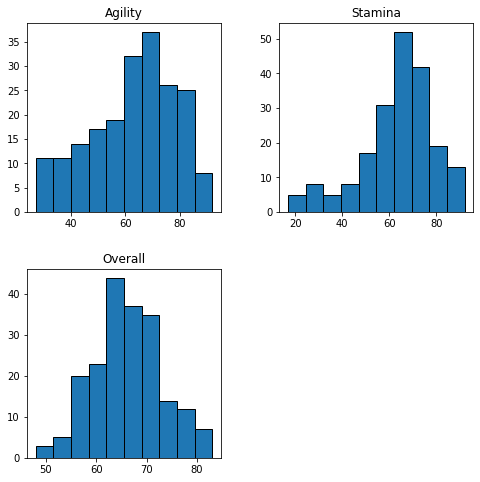

In [23]:
sample[['Agility', 'Stamina', 'Overall']].hist(figsize=(8,8.), grid=False, ec='black');

In [24]:
sample['Preferred Foot'].describe()

count       200
unique        2
top       Right
freq        155
Name: Preferred Foot, dtype: object

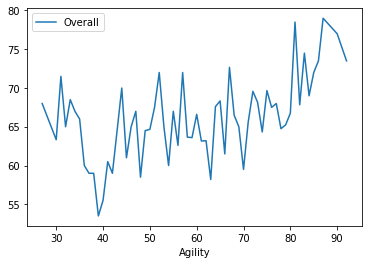

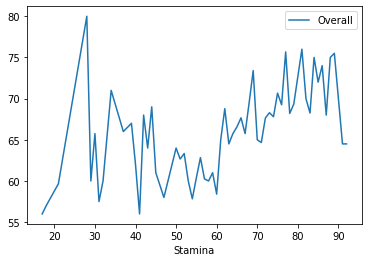

In [25]:
sample[['Overall', 'Agility']].groupby('Agility', as_index=False).mean().plot('Agility', 'Overall');
sample[['Overall', 'Stamina']].groupby('Stamina', as_index=False).mean().plot('Stamina', 'Overall');

From the graphs, it seems that the overall rating fluctuates wildly between different values of Agility and Stamina. However, there does seem to be a slight upwards trend in both graphs, it seems that generally when Stamina or Agility increase Overall also increases. from these graphs it is difficult to determine which variable affects Overall more.

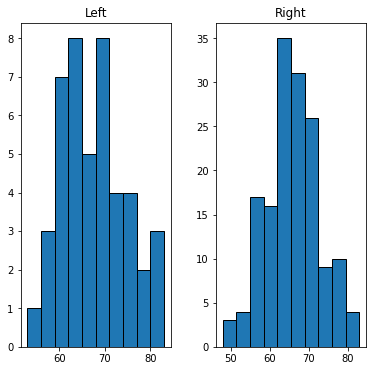

In [26]:
sample.hist('Overall', by='Preferred Foot', bins=10, figsize=(6,6), xrot=360, ec='black');

**Finding Coefficients**

In [27]:
model_sample = smf.ols('Overall ~ Agility + Stamina + Preferred_Foot', sample).fit()
model_sample.params

Intercept         53.386748
Agility            0.077061
Stamina            0.139271
Preferred_Foot    -0.607783
dtype: float64

In this case, we got small coefficients and a large constant. For Agility and Stamina we see that the model thinks Agility and Stamina have a positive effect on Overall (i.e. Higher Stamina/Agility leads to higher Overall) but changing Stamina or Agility by a single unit barely affects the Overall score. Also our model gives negative weight to Preferred_Foot, meaning that the Overall rating of right-footed players is lower according to the model.

**Anova Table, R Squared, R Squared Adj, F Pvalue**

In [28]:
anova = {'Source of Variation': ['Reg', 'Res', 'Total'], 'SS': [model_sample.ess, np.sum(model_sample.resid**2), model_sample.centered_tss], 'df': [3, 196, 199], 'MS': [model_sample.mse_model, model_sample.mse_resid, None], 'F': [model_sample.mse_model/model_sample.mse_resid, None, None]}
pd.DataFrame(data=anova)

,Source of Variation,SS,df,MS,F
0,Reg,1770.335706,3,590.111902,15.551886
1,Res,7437.164294,196,37.944716,NaN
2,Total,9207.500000,199,NaN,NaN


In [29]:
print('R^2: %.3f' % model_sample.rsquared)
print('R^2_adj: %.3f' % model_sample.rsquared_adj)
print('F Pvalue:', model_sample.f_pvalue)

R^2: 0.192
R^2_adj: 0.180
F Pvalue: 4.09877469101466e-09


**Confidence Intervals for beta**

In [30]:
C = np.ones((200,4))
C[:,1:] = sample[['Agility', 'Stamina', 'Preferred_Foot']].to_numpy()
C = np.linalg.inv((C.T@C))
var_error = np.sum(model_sample.resid**2)/196
conf_int = {'Parameter': [], 'Low': [], 'High': []}
for i in range(4):
    b_hat = model_sample.params[i]
    ci_low = b_hat - t.ppf(0.975, 196)*np.sqrt(var_error*C[i][i])
    ci_high = b_hat + t.ppf(0.975, 196)*np.sqrt(var_error*C[i][i])
    conf_int['Parameter'].append('b%s' % i)
    conf_int['Low'].append(ci_low)
    conf_int['High'].append(ci_high)
pd.DataFrame(data=conf_int)

,Parameter,Low,High
0,b0,47.560938,59.212559
1,b1,0.014445,0.139678
2,b2,0.076074,0.202468
3,b3,-2.681851,1.466286


In [31]:
model_data = smf.ols('Overall ~ Agility + Stamina + Preferred_Foot', data).fit()
model_data.params

Intercept         55.176439
Agility            0.039248
Stamina            0.138124
Preferred_Foot    -0.085453
dtype: float64

All coefficients based on the full data are in the confidence intervals.

**Likelihood Ratio Test**

$$ H_0: \beta_1=\beta_2=\beta_3=0 $$
$$ H_1: \exists {j>0}, \beta_j\neq{0} $$

We will use the likelihood ratio test to determine if our model represents the data better than the null model. To use the likelihood ratio test we assume that our errors come from N(0,$\sigma^2$) and that the errors are independant. Additionally we assume that there exists some $\beta_0,\beta_1,\beta_2,\beta_3$ such that $Overall = \beta_0 + \beta_1*Agility + \beta_2*Stamina + \beta_3*PreferredFoot$.
The test statistic is $log(L(\hat{\beta_{0, F}},\hat{\beta_{1, F}},\hat{\beta_{2, F}},\hat{\beta_{3, F}}, \hat{\sigma_F})) - log(L(\hat{\beta_{0, N}},0,0,0, \hat{\sigma_N}))$.
Under $H_0$ the test statistic is distributed $\chi^2_3$

In [32]:
null_model = smf.ols('Overall ~ 1', sample).fit()
print('Likelihood Ratio Pvalue:', model_sample.compare_lr_test(null_model)[1])

Likelihood Ratio Pvalue: 2.8417260674526844e-09


The pvalue is small enough to reject $H_0$ under any reasonable confidence level.

**Residue Analysis**

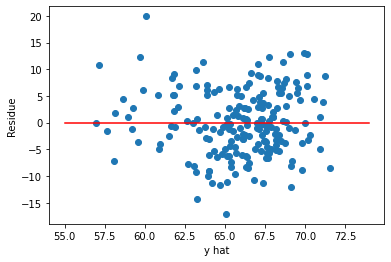

In [33]:
plt.scatter(model_sample.fittedvalues, model_sample.resid);
plt.xlabel('y hat')
plt.ylabel('Residue')
plt.plot(range(55, 75), np.zeros((20,)), color='red');

 The points are symmetrical (more or less) around the X axis. This leads us to conclude that our model is unbiased and that it is reasonable to assume that the error is distributed normally. Additionally, we see that the "width" between the points is roughly equal across the graph. Thus we conclude that homoscedasticity is a reasonable assumption. Overall, it seems that the linearity assumption is reasonable.

**Testing the Model**

In [34]:
test_sample = data.drop(sample.index).sample(1000, random_state=1)
test_sample['const'] = 1
predictions = model_sample.get_prediction(test_sample)
test_sample_numpy = test_sample[['const', 'Agility', 'Stamina', 'Preferred_Foot']].to_numpy()
ci_low = model_sample.params@test_sample_numpy.T - t.ppf(0.975, 196)*np.sqrt(var_error)*np.sqrt(np.diag(test_sample_numpy@C@test_sample_numpy.T)+1)
ci_high = model_sample.params@test_sample_numpy.T + t.ppf(0.975, 196)*np.sqrt(var_error)*np.sqrt(np.diag(test_sample_numpy@C@test_sample_numpy.T)+1)
in_ci = (ci_low < test_sample['Overall']) & (test_sample['Overall'] < ci_high)
in_ci.mean()

0.937

In this case, we got that 93.7% of the real values are in the confidence intervals. The confidence intervals are based on the linearity assumption and normal errors assumption, among others. The fact that our confidence intervals are "working as intended" shows that our assumptions are reasonable.

**Model with First Order Interactions**

In [35]:
new_model_sample = smf.ols('Overall ~ Agility * Stamina * Preferred_Foot - Agility:Stamina:Preferred_Foot ', sample).fit()
new_model_sample.aic, new_model_sample.bic, new_model_sample.rsquared, new_model_sample.rsquared_adj

(1299.3951673461902,
 1322.4833889120264,
 0.21365331713512659,
 0.18920730626886095)

In [36]:
model_sample.aic, model_sample.bic, model_sample.rsquared, model_sample.rsquared_adj
sample_lin = sample

The new model has a higher AIC and a higher BIC than the previous model. It also has a higher $R^2$ coefficent and a higher $R^2_{adj}$ coefficent. Based on these metrics, we will prefer the new model.

# Section II - Logistic regression

In this section we will check the effects of the Agility rating, Stamina rating and Week Foot on the Preffered Foot of a player.

In [37]:
data = fifa.loc[:, ('Weak Foot', 'Stamina', 'Agility', 'Preferred Foot')]
data['Preferred_Foot'] = data.apply(lambda row: 0 if row['Preferred Foot'] == 'Left' else 1, axis=1)
del data['Preferred Foot']
data = data.rename({'Weak Foot' : 'Weak_Foot'}, axis=1)
sample = data.sample(200, random_state=0)

**Initial Data Visualization**

In [38]:
sample['Weak_Foot'].describe()

count    200.00000
mean       2.96500
std        0.62909
min        1.00000
25%        3.00000
50%        3.00000
75%        3.00000
max        5.00000
Name: Weak_Foot, dtype: float64

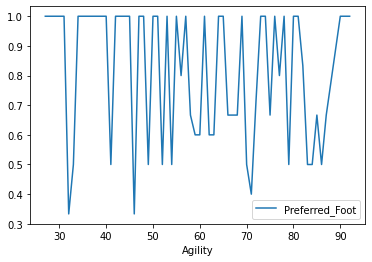

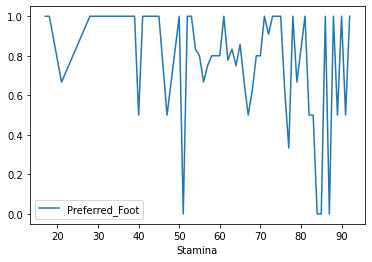

In [39]:
sample[['Preferred_Foot', 'Agility']].groupby('Agility', as_index=False).mean().plot('Agility', 'Preferred_Foot');
sample[['Preferred_Foot', 'Stamina']].groupby('Stamina', as_index=False).mean().plot('Stamina', 'Preferred_Foot');

Seems that stamina has a slight impact on Preferred_Foot, the less stamina a player has, the more likely he is to prefere his right foot while Agility seems not to have impact on Preferred Foot.

In [40]:
log_reg = smf.logit(formula = str('Preferred_Foot ~ Agility + Stamina + Weak_Foot'), data = sample).fit()
log_reg.params

Optimization terminated successfully.
         Current function value: 0.509603
         Iterations 6


Intercept    1.011460
Agility     -0.004538
Stamina     -0.024984
Weak_Foot    0.732844
dtype: float64

We got small negative parameters for Agility and Stamina meaning that they barely affects the Preferred Foot foot of a player according to the model. Weak foot has a larger positive coefficient meaning that right footed players has larger value of Weak Foot, in other words, a player that playes well with his weak foot more likely to right footed. Here, increasing a parameter in one unit will affect the explained variable by e to the power of its coefficient.

**Confidence intervals for beta coefficients**

In [41]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         Preferred_Foot   No. Observations:                  200
Model:                          Logit   Df Residuals:                      196
Method:                           MLE   Df Model:                            3
Date:                Sun, 11 Dec 2022   Pseudo R-squ.:                 0.04419
Time:                        13:21:32   Log-Likelihood:                -101.92
converged:                       True   LL-Null:                       -106.63
Covariance Type:            nonrobust   LLR p-value:                   0.02415
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0115      1.096      0.922      0.356      -1.138       3.161
Agility       -0.0045      0.013     -0.349      0.727      -0.030       0.021
Stamina       -0.0250      0.013     -1.854      0.064      -0.051       0.001
Weak_Foot      0.7328      0.307      2.385      0.017       0.131       1.335
==============================================================================
"""

In [42]:
model_data = smf.logit('Preferred_Foot ~ Agility + Stamina + Weak_Foot', data).fit()
model_data.params

Optimization terminated successfully.
         Current function value: 0.527923
         Iterations 6


Intercept    1.766665
Agility     -0.019403
Stamina     -0.009447
Weak_Foot    0.442527
dtype: float64

All betas of the full data are in the confidence intervals

**Adding interactions to the model**

In [43]:
new_log_reg = smf.logit('Preferred_Foot ~ Agility * Stamina * Weak_Foot - Agility:Stamina:Weak_Foot ', sample).fit()
new_log_reg.aic, new_log_reg.bic

Optimization terminated successfully.
         Current function value: 0.503438
         Iterations 6


(215.3753954519084, 238.46361701774464)

In [44]:
log_reg.aic, log_reg.bic

(211.84130131536267, 225.0345707815548)

The new model has higher AIC & BIC, thus we prefere it.

Now we will use all columns allowing first order interactions, performing forward/backward stepwise regression using BIC score.

**Forward stepwise regression with BIC score**

In [45]:
from itertools import combinations

features = data.loc[:, data.columns != 'Preferred_Foot']
target = data.loc[:, data.columns == 'Preferred_Foot']
BICs = {}
input_str = 'Preferred_Foot ~ '
best_model = ''
best_BIC = 0
for k in range(1, 3):
    for feature in combinations(features, k):
        
        if len(input_str) - len('Preferred_Foot ~ ') == 0:
            input_str = input_str + '%s ' % (feature[0])
        elif len(feature) <= 1:
            input_str = input_str + '+ %s ' % (feature[0])
        else:
            input_str = input_str + '+ %s * %s ' % (feature[0], feature[1])
        
        model = smf.logit(input_str, data).fit()
        
        if len(BICs) == 0:
            BICs[str(input_str)] = model.bic
            best_model = input_str
            best_BIC = model.bic
        
        if model.bic > max(BICs.values()):
            BICs[str(input_str)] = model.bic
            best_model = input_str
            best_BIC = model.bic
        else:
            continue
            
output = best_model.split(' ~ ')     
print('best model found: target is: %s, features: %s, its BIC score is %d' % (output[0], output[1], best_BIC))

Optimization terminated successfully.
         Current function value: 0.538923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525077
         Iterations 6
best model found: target is: Preferred_Foot, features: Weak_Foot , its BIC score is 19592


**Backward stepwise regression with BIC score**

In [46]:
features = data.loc[:, data.columns != 'Preferred_Foot']
target = data.loc[:, data.columns == 'Preferred_Foot']
BICs = {}
input_str = 'Preferred_Foot ~'
best_model = ''
best_BIC = 0
model = []

for k in range(1, 3):
    for feature in combinations(features, k):
        model.append(feature)
model.reverse()

for feature in model:
    if len(input_str) - len('Preferred_Foot ~') == 0:
        input_str = input_str + ' %s * %s' % (feature[0], feature[1])
    elif len(feature) == 2:
        input_str = input_str + ' + %s * %s' % (feature[0], feature[1])
    else:
        input_str = input_str + ' + %s' % (feature[0])

log_reg = smf.logit(input_str, data).fit()
BICs[str(input_str)] = log_reg.bic
best_model = input_str
best_BIC = log_reg.bic

while len(model) >= 1:
    model.pop(0)
    input_str = 'Preferred_Foot ~'
    for feature in model:
         if len(input_str) - len('Preferred_Foot ~') == 0:
            if len(feature) == 2:
                input_str = input_str + ' %s * %s' % (feature[0], feature[1])
            elif len(feature) == 1:
                input_str = input_str + ' %s' % (feature[0])
         elif len(feature) == 2:
            input_str = input_str + ' + %s * %s' % (feature[0], feature[1])
         else:
            input_str = input_str + ' + %s' % (feature[0])

         log_reg = smf.logit(input_str, data).fit()

         if log_reg.bic > max(BICs.values()):
            BICs[str(input_str)] = log_reg.bic
            best_model = input_str
            best_BIC = log_reg.bic
            model.pop(0)
         else:
            model.pop(0)
            continue
        
output = best_model.split(' ~ ')     
print('best model found: target is: %s, features: %s, its BIC score is %d' % (output[0], output[1], best_BIC))

Optimization terminated successfully.
         Current function value: 0.525077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538923
         Iterations 5
best model found: target is: Preferred_Foot, features: Weak_Foot, its BIC score is 19592


The two methods led to the same result

**Forward stepwise regression with AIC score**

In [47]:
features = data.loc[:, data.columns != 'Preferred_Foot']
target = data.loc[:, data.columns == 'Preferred_Foot']
AICs = {}
input_str = 'Preferred_Foot ~ '
best_model = ''
best_AIC = 0
for k in range(1, 3):
    for feature in combinations(features, k):
        
        if len(input_str) - len('Preferred_Foot ~ ') == 0:
            input_str = input_str + '%s ' % (feature[0])
        elif len(feature) <= 1:
            input_str = input_str + '+ %s ' % (feature[0])
        else:
            input_str = input_str + '+ %s * %s ' % (feature[0], feature[1])
        
        model = smf.logit(input_str, data).fit()
        
        if len(AICs) == 0:
            AICs[str(input_str)] = model.aic
            best_model = input_str
            best_AIC = model.aic
        
        if model.aic > max(AICs.values()):
            AICs[str(input_str)] = model.aic
            best_model = input_str
            best_AIC = model.aic
        else:
            continue
            
output = best_model.split(' ~ ')     
print('best model found: target is: %s, features: %s, its AIC score is %d' % (output[0], output[1], best_AIC))

Optimization terminated successfully.
         Current function value: 0.538923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525077
         Iterations 6
best model found: target is: Preferred_Foot, features: Weak_Foot , its AIC score is 19576


**Backward stepwise regression with AIC score**

In [48]:
features = data.loc[:, data.columns != 'Preferred_Foot']
target = data.loc[:, data.columns == 'Preferred_Foot']
AICs = {}
input_str = 'Preferred_Foot ~'
best_model = ''
best_AIC = 0
model = []

for k in range(1, 3):
    for feature in combinations(features, k):
        model.append(feature)
model.reverse()

for feature in model:
    if len(input_str) - len('Preferred_Foot ~') == 0:
        input_str = input_str + ' %s * %s' % (feature[0], feature[1])
    elif len(feature) == 2:
        input_str = input_str + ' + %s * %s' % (feature[0], feature[1])
    else:
        input_str = input_str + ' + %s' % (feature[0])

log_reg = smf.logit(input_str, data).fit()
AICs[str(input_str)] = log_reg.aic
best_model = input_str
best_AIC = log_reg.aic

while len(model) >= 1:
    model.pop(0)
    input_str = 'Preferred_Foot ~'
    for feature in model:
         if len(input_str) - len('Preferred_Foot ~') == 0:
            if len(feature) == 2:
                input_str = input_str + ' %s * %s' % (feature[0], feature[1])
            elif len(feature) == 1:
                input_str = input_str + ' %s' % (feature[0])
         elif len(feature) == 2:
            input_str = input_str + ' + %s * %s' % (feature[0], feature[1])
         else:
            input_str = input_str + ' + %s' % (feature[0])

         log_reg = smf.logit(input_str, data).fit()

         if log_reg.aic > max(AICs.values()):
            AICs[str(input_str)] = log_reg.aic
            best_model = input_str
            best_AIC = log_reg.aic
            model.pop(0)
         else:
            model.pop(0)
            continue
        
output = best_model.split(' ~ ')     
print('best model found: target is: %s, features: %s, its AIC score is %d' % (output[0], output[1], best_AIC))

Optimization terminated successfully.
         Current function value: 0.525077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538923
         Iterations 5
best model found: target is: Preferred_Foot, features: Weak_Foot, its AIC score is 19576


AIC score is identical for both forward & backward

AIC and BIC score are almost the same and giving the same model as a result, it means that the Weak_Foot feature is highly correlated with Preferred_Foot relatively to the rest of features.

# Part IV

# Section I - Bootstrap

**Bootstrap Confidence Intervals**

In this section we will build confidence intervals for $\beta_0^*,...,\beta_k^*$ from Part III using different bootstrap techniques. 

**Confidence Interval Without Bootstrap**

In [49]:
data = fifa.loc[:, ('Overall', 'Stamina', 'Agility', 'Preferred Foot')]
data['Preferred_Foot'] = data.apply(lambda row: 1 if row['Preferred Foot'] == 'Left' else 2, axis=1)
model_sample = smf.ols('Overall ~ Agility + Stamina + Preferred_Foot', sample_lin).fit()
model_sample.conf_int()

,0,1
Intercept,47.560938,59.212559
Agility,0.014445,0.139678
Stamina,0.076074,0.202468
Preferred_Foot,-2.681851,1.466286


**Bootstrap Confidence Interval - Normal Approximation**

In [50]:
B = 400
features = ['Agility', 'Stamina', 'Preferred_Foot', 'Overall']
parameters = {'b0' : [], "b1" : [], "b2" : [], "b3" : [] }

for _ in  range(B):
    model_sample1 = smf.ols('Overall ~ Agility + Stamina + Preferred_Foot', data.sample(200)).fit()
    for i in range(len(model_sample1.params)):
        parameters[f'b{i}'].append(model_sample1.params[i])


var_list = {}
for parameter in parameters:
    mean = sum(parameters[parameter])/B
    var_list[parameter] = 1/B * sum((t - mean)**2 for t in parameters[parameter])

conf_int = {'Parameter': [], 'Low': [], 'High': []}
for i in range(4):
    b_hat = model_sample.params[i]
    ci_low = b_hat -  norm.ppf(0.975)*np.sqrt(var_list[f'b{i}'])
    ci_high = b_hat +  norm.ppf(0.975)*np.sqrt(var_list[f'b{i}'])
    conf_int['Parameter'].append('b%s' % i)
    conf_int['Low'].append(ci_low)
    conf_int['High'].append(ci_high)
    
pd.DataFrame(data=conf_int)

,Parameter,Low,High
0,b0,47.143799,59.629698
1,b1,0.004403,0.149720
2,b2,0.067221,0.211322
3,b3,-2.646797,1.431232


**Bootstrap Confidence Interval - Pivot**

In [51]:
B = 400
SQRT_N = np.sqrt(200)
features = ['Agility', 'Stamina', 'Preferred_Foot', 'Overall']
temp_df = {'Agility' : [], 'Stamina' : [], 'Preferred_Foot' : [], 'Overall' : []}
parameters = {'b0' : [], "b1" : [], "b2" : [], "b3" : [] }

for _ in  range(B):
    model_sample2 = smf.ols('Overall ~ Agility + Stamina + Preferred_Foot', data.sample(200)).fit()
    for i in range(len(model_sample2.params)):
        parameters[f'b{i}'].append(-SQRT_N*(model_sample.params[i] - model_sample2.params[i]))

pdf = {}
for parameter in parameters:
    pdf[parameter] = [np.quantile(parameters[parameter], 0.975), np.quantile(parameters[parameter], 0.025)]
    
conf_int1 = {'Parameter': [], 'Low': [], 'High': []}
for i in range(4):
    b_hat =  model_sample.params[i]
    ci_low = b_hat -  pdf[f'b{i}'][0]/SQRT_N
    ci_high = b_hat -  pdf[f'b{i}'][1]/SQRT_N
    conf_int1['Parameter'].append('b%s' % i)
    conf_int1['Low'].append(ci_low)
    conf_int1['High'].append(ci_high)
    
pd.DataFrame(data=conf_int1)

,Parameter,Low,High
0,b0,45.259422,57.855895
1,b1,0.036712,0.175156
2,b2,0.070593,0.212987
3,b3,-2.990568,1.095658


**Bootstrap Confidence Interval - Quantiles**

In [52]:
B = 400
SQRT_N = np.sqrt(200)
features = ['Agility', 'Stamina', 'Preferred_Foot', 'Overall']
temp_df = {'Agility' : [], 'Stamina' : [], 'Preferred_Foot' : [], 'Overall' : []}
parameters = {'b0' : [], "b1" : [], "b2" : [], "b3" : [] }

for _ in  range(B):
    model_sample2 = smf.ols('Overall ~ Agility + Stamina + Preferred_Foot', data.sample(200)).fit()
    for i in range(len(model_sample2.params)):
        parameters[f'b{i}'].append(model_sample2.params[i])

pdf = {}
for parameter in parameters:
    pdf[parameter] = [np.quantile(parameters[parameter], 0.975), np.quantile(parameters[parameter], 0.025)]
    
conf_int2 = {'Parameter': [], 'Low': [], 'High': []}
for i in range(4):
    b_hat =  model_sample.params[i]
    ci_low = pdf[f'b{i}'][1]
    ci_high = pdf[f'b{i}'][0]
    conf_int2['Parameter'].append('b%s' % i)
    conf_int2['Low'].append(ci_low)
    conf_int2['High'].append(ci_high)
    
pd.DataFrame(data=conf_int2)

,Parameter,Low,High
0,b0,49.185050,61.827967
1,b1,-0.027979,0.119815
2,b2,0.057879,0.210982
3,b3,-2.187349,1.862638


**Comparison**

In [53]:
ci_length = {'Parameter': ['b0', 'b1', 'b2', 'b3'], 'No Bootstrap': [], 'Normal Approximation': [], 'Pivot': [], 'Quantiles': []}
for i in range(4):
    ci_length['No Bootstrap'].append(model_sample.conf_int()[1][i] - model_sample.conf_int()[0][i])
    ci_length['Normal Approximation'].append(conf_int['High'][i] - conf_int['Low'][i])
    ci_length['Pivot'].append(conf_int1['High'][i] - conf_int1['Low'][i])
    ci_length['Quantiles'].append(conf_int2['High'][i] - conf_int2['Low'][i])
pd.DataFrame(data=ci_length)

,Parameter,No Bootstrap,Normal Approximation,Pivot,Quantiles
0,b0,11.651621,12.485900,12.596473,12.642917
1,b1,0.125233,0.145317,0.138444,0.147794
2,b2,0.126394,0.144101,0.142394,0.153104
3,b3,4.148137,4.078029,4.086226,4.049987


We can see that the length of the confidence interval was about the same for all methods.

In [54]:
ci_star = {'Parameter': ['b0*', 'b1*', 'b2*', 'b3*'], 'Value': smf.ols('Overall ~ Agility + Stamina + Preferred_Foot', data).fit().params, 'No Bootstrap': [], 'Normal Approximation': [], 'Pivot': [], 'Quantiles': []}
for i in range(4):
    ci_star['No Bootstrap'].append(model_sample.conf_int()[0][i] < ci_star['Value'][i] < model_sample.conf_int()[1][i])
    ci_star['Normal Approximation'].append(conf_int['Low'][i] < ci_star['Value'][i] < conf_int['High'][i])
    ci_star['Pivot'].append(conf_int1['Low'][i] < ci_star['Value'][i] < conf_int1['High'][i])
    ci_star['Quantiles'].append(conf_int2['Low'][i] < ci_star['Value'][i] < conf_int2['High'][i])
pd.DataFrame(data=ci_star)

,Parameter,Value,No Bootstrap,Normal Approximation,Pivot,Quantiles
Intercept,b0*,55.176439,True,True,True,True
Agility,b1*,0.039248,True,True,True,True
Stamina,b2*,0.138124,True,True,True,True
Preferred_Foot,b3*,-0.085453,True,True,True,True


**Bootstrap for Prediction**

In [55]:
test_sample = data.drop(sample_lin.index).sample(100, random_state=1)
test_sample['const'] = 1
test_sample_numpy = test_sample[['const', 'Agility', 'Stamina', 'Preferred_Foot']].to_numpy()
predictions = model_sample.params@test_sample_numpy.T
test_sample
predictions

array([67.23460735, 67.68773015, 64.36567824, 70.99827016, 64.61451722,
       68.56510982, 68.7015782 , 68.68082025, 67.9222544 , 65.63116812,
       67.29037388, 66.04898178, 65.64601985, 66.6088695 , 68.95322003,
       65.96911747, 67.56665048, 68.04947673, 68.59815311, 62.08998068,
       65.30807049, 69.89561228, 69.18440445, 58.37981856, 67.8298042 ,
       63.68417386, 60.16064098, 68.26020375, 68.72817827, 67.47139745,
       63.058973  , 68.2305003 , 63.15679243, 63.89770372, 65.83264909,
       68.27451849, 59.52369179, 64.49934378, 70.01132272, 65.23100902,
       60.82168796, 63.30781199, 68.6511168 , 69.0098241 , 69.4304406 ,
       69.88356339, 68.38462325, 65.42408148, 66.28016621, 62.81884308,
       66.07868524, 68.56844965, 67.84185309, 70.79344936, 59.14763047,
       66.37488224, 67.65522385, 66.72768332, 67.17520044, 66.89999783,
       64.96141208, 64.91435461, 67.56050781, 63.14474354, 66.55870865,
       68.20079684, 64.00727148, 64.04538345, 64.69802192, 68.42

# Section II

We will focus on 'Preferred Foot' column wich has two categories in it: right and left.

In [56]:
data = fifa.filter(items=['Preferred Foot', 'Overall'])
data.groupby('Preferred Foot').mean()

,Overall
Preferred Foot,
Left,66.801472
Right,66.083381


**Research question:** Are Overall score values in left bigger than values in right? 

Define: **m_l** as expectation of left, **m_r** as expectation of right and **d** as the difference between them (m_l - m_r)

Estimate all definitions:

In [57]:
sample = data.sample(200, random_state=0)
B = 400

m_r = sample.loc[sample['Preferred Foot'] == 'Right']['Overall']
samples_r = []
for _ in range(B):
    r = np.random.choice(m_r, size=len(m_r), replace=True)
    samples_r.append(r.mean())
print(f'Estomator for mean of Right is : {sum(samples_r) / len(samples_r)}')

m_l = sample.loc[sample['Preferred Foot'] == 'Left']['Overall']
samples_l = []
for _ in range(B):
    l = np.random.choice(m_l, size=len(m_l), replace=True)
    samples_l.append(l.mean())
print(f'Estomator for mean of Left is : {sum(samples_l) / len(samples_l)}')

samples_d = []
for _ in range(B):
    l = np.random.choice(m_l, size=len(m_l), replace=True)
    r = np.random.choice(m_r, size=len(m_r), replace=True)
    samples_d.append(l.mean() - r.mean())
print(f'Estimator for difference of means is: {sum(samples_d) / len(samples_d)}')

Estomator for mean of Right is : 65.63190322580641
Estomator for mean of Left is : 67.13583333333338
Estimator for difference of means is: 1.3760967741935481


All estimators are MLE's, Average is an MLE of expectation and d is MLE because invariant of MLE.

Confidence interval for d from the 200 samples

In [58]:
temp = 0
temp1 = 0 
for i in range(len(samples_d)):
    temp = temp + samples_d[i]**2
    temp1 = temp1 + samples_d[i]
se_boot_d = (temp / B + (temp1 / B)**2)**0.5

d = sum(samples_d) / len(samples_d)

print('Confidence interval for mean difference is :')
print([d - se_boot_d, d + se_boot_d])

Confidence interval for mean difference is :
[-0.8855468374115973, 3.6377403857986934]


Estimate d based on all data

In [59]:
m_r_data = data.loc[data['Preferred Foot'] == 'Right']['Overall']
m_l_data = data.loc[data['Preferred Foot'] == 'Left']['Overall']
d_all = m_l_data.values.mean() - m_r_data.values.mean()
print(d_all)

0.7180912044512837


d from all data is in the confidence interval

Permutation test for search question (sample is large and there are ties so can be approximated)

In [60]:
import random
y = len(m_l)
d_list = []
B = 400
observations = m_l.values.tolist() + m_r.values.tolist()
x_temp, y_temp = [], []

for i in range(B):
    random.shuffle(observations)
    x_temp = observations[:y]
    y_temp = observations[y:]
    d_list.append((sum(y_temp) / len(y_temp)) - (sum(x_temp) / len(x_temp)))
    
bigger = 0
for i in range(len(d_list)):
    if d_list[i] >= d:
        bigger = bigger + 1

print('p value is:')
print(bigger / B)

p value is:
0.125


According to permutation test we should **not** reject the null hypothisis (alpha = 0.05)

In [61]:
from scipy.stats import norm
w = (d - 0)**2 / (se_boot_d**2)
rej = norm.ppf(0.975)
if abs(w) > rej:
    print(False)
else:
    print(True)

True


According to wald test we should reject null hypothisis

Define **med_l** and **med_r** to be the medians of the categoreis

In [62]:
samples_r_med = []
for _ in range(B):
    r = np.random.choice(m_r, size=len(m_r), replace=True)
    samples_r_med.append(np.median(r))
print(f'Estomator for median of Right is : {np.median(samples_r_med)}')

samples_l_med = []
for _ in range(B):
    l = np.random.choice(m_l, size=len(m_l), replace=True)
    samples_l_med.append(np.median(l))
print(f'Estomator for median of Left is : {np.median(samples_l_med)}')

samples_d_med = []
for _ in range(B):
    l = np.random.choice(m_l, size=len(m_l), replace=True)
    r = np.random.choice(m_r, size=len(m_r), replace=True)
    samples_d_med.append(np.median(l) - np.median(r))
print(f'Estomator for median difference is : {np.median(samples_d_med)}')

Estomator for median of Right is : 66.0
Estomator for median of Left is : 67.0
Estomator for median difference is : 1.0


Since samples comes from a normal distribution wich is symetric, the median is very close to MLE, and so because MLE invariant d is also MLE, the median difference is also normally distributed.

Confidence interval for d_med

In [63]:
temp = 0
temp1 = 0 
for i in range(len(samples_d_med)):
    temp = temp + samples_d_med[i]**2
    temp1 = temp1 + samples_d_med[i]
se_boot_d_med = (temp / B + (temp1 / B)**2)**0.5

d_med = sum(samples_d_med) / len(samples_d_med)

print('Confidence interval for median difference is :')
print([d_med - se_boot_d_med, d_med + se_boot_d_med])

Confidence interval for median difference is :
[-1.2167332597188107, 3.3717332597188108]


d_med from all data

In [64]:
d_med_all = np.median(m_l_data.values) - np.median(m_r_data.values)
print(d_med_all)

1.0


Median difference from all data is in the confidence interval

Permutation test

In [65]:
from itertools import permutations
d_med_list = []
B = 400
observations = m_r.values.tolist() + m_l.values.tolist()
x_temp, y_temp = [], []
for i in range(400):
    random.shuffle(observations)
    x_temp = observations[:y]
    y_temp = observations[y:]
    d_med_list.append(np.median(x_temp) - np.median(y_temp))

bigger = 0
for i in range(len(d_med_list)):
    if d_med_list[i] >= d_med:
        bigger = bigger + 1

print('p value is:')
print(bigger / B)

p value is:
0.1175


According to permutation test we should **not** reject the null hypothisis.

In [66]:
print((m_r.values.std())**2)
print((m_l.values.std())**2)

44.90347554630591
48.398024691358025


Variances of sample categories are different so can't perform a t-test here.

Wald test can be performed here because the assumption the samples are coming from normal distributions thus their medians is likely to normally distribute and also difference between them is normally distribute, the estimator  is asymptotically normal as Wald test assumes.

Define **s_l** as the sum of degrees of sample from left category.

In [67]:
hist = []
temp_rank = []
x_temp = []
ranks = {}

for i in range(1, 101):
    hist.append(sample.loc[sample['Overall'] == i].count() + 1)

observations = m_l.values.tolist()
# deal with ties:
for i in observations:
    for j in range(hist[i].values[1]):
        temp_rank.append(i + j)
    ranks[i] = sum(temp_rank) / len(temp_rank)
    temp_rank = []
s_l = sum(ranks.values())

# As we saw in tutorial 9 n,m > 30 thus can perform normal approximation, need to calculate expectation and sd of s_l

expectation_s_l = 0.5*(len(m_l) + len(m_r) + 1)
se_s_l = ((1/12)*(len(m_l)*len(m_r)*(len(m_l) + len(m_r) + 1)))**0.5

s_l_norm = (s_l - expectation_s_l) / se_s_l
rej = norm.ppf(0.95)
if s_l_norm < rej:
    print(False)
else:
    print(True)

True



According to the test with normal approximation, reject null hypothisis

Now test based on sampling

In [68]:
y = len(m_l)
B = 400
hist = []
temp_rank = []
ranks = {}
s_l_list = []
observations = m_l.values.tolist() + m_r.values.tolist()
for i in range(1, 101):
    hist.append(sample.loc[sample['Overall'] == i].count() + 1)
    
x_temp = []
for i in range(B):
    random.shuffle(observations)
    x_temp = observations[:y]
    
    # deal with ties:
    for i in x_temp:
        for j in range(hist[i].values[1]):
            temp_rank.append(i + j)
        ranks[i] = sum(temp_rank) / len(temp_rank)
        temp_rank = []
    s_l_list.append(sum(ranks.values()))
      
smaller = 0
for i in range(len(s_l_list)):
    if s_l_list[i] <= s_l:
        smaller = smaller + 1

print('Reject if p value less than 0.05')
print(f'P value is: {smaller / B}')

Reject if p value less than 0.05
P value is: 0.0025


According to permutation test based on sampling, can reject the null hypothisis.

# Part V

# Section I

Research question: does the distribution of 'Overall' in 'Left' category is different than 'Overall' in 'Right' category?

Spliting the 1200 sample as requested

In [69]:
data = fifa.loc[:, ('Overall', 'Preferred Foot')]
data['Preferred_Foot'] = data.apply(lambda row: 1 if row['Preferred Foot'] == 'Left' else 0, axis=1)
data['z'] = data.apply(lambda row: 1 if row['Overall'] > data['Overall'].median() else 0, axis=1)
sample = data.sample(1200, random_state=0)
sample_200 = sample.iloc[:200,:]
sample_1000 = sample.iloc[201:,:]

Estimation of psi and bootstrap based CI

In [70]:
import scipy.stats as stats
B = 400
log_odds_ration_list = []
for _ in range(B):
    temp_sample = data.sample(n=200)
    temp_con_table = pd.crosstab(temp_sample['z'],temp_sample['Preferred_Foot'], rownames='Z', colnames='Y')
    temp_odds_ratio, _ = stats.fisher_exact(temp_con_table)
    log_odds_ration_list.append(np.log(temp_odds_ratio))
    
boot_psi_est = (1 / B) * np.sum(log_odds_ration_list)
print(f'Estimated psi is: {boot_psi_est}')
print(f'Bootstrap based confidence interval for psi is: {[np.quantile(log_odds_ration_list, 0.025), np.quantile(log_odds_ration_list, 0.975)]}')

Estimated psi is: 0.11278743143211799
Bootstrap based confidence interval for psi is: [-0.6078212508718858, 0.8037554672134357]


Credible interval for psi (Uniform prior Beta(1,1)) follows the course book 11.4

In [71]:
B = 200
r = len(sample_200[sample_200['Preferred_Foot'] == 0])
l = len(sample_200[sample_200['Preferred_Foot'] == 1])
s_r = sample_200[sample_200['Preferred_Foot'] == 0]['z'].sum()
s_l = sample_200[sample_200['Preferred_Foot'] == 1]['z'].sum()
p_l = np.random.beta(s_l + 1, l - s_l + 1, B)
p_r = np.random.beta(s_r + 1, r - s_r + 1, B)
eta_l = [np.log(p / (1 - p)) for p in p_l]
eta_r = [np.log(p / (1 - p)) for p in p_r]
psi = [(eta_1 - eta_2) for eta_1, eta_2 in zip(eta_l, eta_r)]
uni_prior_psi = sum(psi) / len(psi)

print(f'Estimated psi is: {uni_prior_psi}')
print(f'Credible interval for psi is: {[np.quantile(psi, 0.025), np.quantile(psi, 0.975)]}')

Estimated psi is: 0.3266214520322378
Credible interval for psi is: [-0.27639144639612706, 0.9712770770939826]


Credible interval for psi (Jeffreys prior Beta(0.5,0.5)) follows the course book 11.4

In [72]:
B = 200
r = len(sample_200[sample_200['Preferred_Foot'] == 0])
l = len(sample_200[sample_200['Preferred_Foot'] == 1])
s_r = sample_200[sample_200['Preferred_Foot'] == 0]['z'].sum()
s_l = sample_200[sample_200['Preferred_Foot'] == 1]['z'].sum()
p_l = np.random.beta(s_l + 0.5, l - s_l + 0.5, B)
p_r = np.random.beta(s_r + 0.5, r - s_r + 0.5, B)
eta_l = [np.log(p / (1 - p)) for p in p_l]
eta_r = [np.log(p / (1 - p)) for p in p_r]
psi = [(eta_1 - eta_2) for eta_1, eta_2 in zip(eta_l, eta_r)]
Jeff_prior_psi = sum(psi) / len(psi)

print(f'Estimated psi is: {Jeff_prior_psi}')
print(f'Credible interval for psi is: {[np.quantile(psi, 0.025), np.quantile(psi, 0.975)]}')

Estimated psi is: 0.32517847633998875
Credible interval for psi is: [-0.30429422797733774, 0.962142628791526]


Now we'll use sample_1000 (past_data) to calculate prior (assuming Beta) to p_l, p_r

In [73]:
import scipy.stats as stats
B = 1000
p_l_list = []
p_r_list = []
for _ in  range(B):
    temp_sample = sample_1000.sample(n=200)
    p_l_list.append(temp_sample[temp_sample['Preferred_Foot'] == 1]['z'].sum() / (len(temp_sample[temp_sample['Preferred_Foot'] == 1])))
    p_r_list.append(temp_sample[temp_sample['Preferred_Foot'] == 0]['z'].sum() / (len(temp_sample[temp_sample['Preferred_Foot'] == 0])))

# Fitting beta distribution and getting its parameter for the priors
a_p_l, b_p_l = stats.beta.fit(p_l_list, floc=0, fscale=1)[: 2]
a_p_r, b_p_r = stats.beta.fit(p_r_list, floc=0, fscale=1)[: 2]

# Now calculate the posterior
l = len(sample_200[sample_200['Preferred_Foot'] == 1])
r = len(sample_200[sample_200['Preferred_Foot'] == 0])
s_r = sample_200[sample_200['Preferred_Foot'] == 0]['z'].sum()
s_l = sample_200[sample_200['Preferred_Foot'] == 1]['z'].sum()
p_l = np.random.beta(s_l + a_p_l, l - s_l + b_p_l, B)
p_r = np.random.beta(s_r + a_p_r, r - s_r + b_p_r, B)
eta_l = [np.log(p / (1 - p)) for p in p_l]
eta_r = [np.log(p / (1 - p)) for p in p_r]
psi = [(eta_1 - eta_2) for eta_1, eta_2 in zip(eta_l, eta_r)]
past_data_psi = sum(psi) / len(psi)

print(f'Estimated psi is: {past_data_psi}')
print(f'Credible interval for psi is: {[np.quantile(psi, 0.025), np.quantile(psi, 0.975)]}')

Estimated psi is: 0.20847079465039398
Credible interval for psi is: [-0.2007624332434312, 0.6329858200793477]


Psi from all data

In [74]:
con_table = pd.crosstab(data['z'],data['Preferred_Foot'], rownames='Z', colnames='Y')
odds_ration, _ = stats.fisher_exact(con_table)
data_psi = np.log(odds_ration)

print(f'Psi from all data is: {data_psi}')

Psi from all data is: 0.13570679849371922


**Comparison**

In [75]:
comparison = {'All Data': data_psi, 'Past data psi': past_data_psi, 'Jeffreys prior psi': Jeff_prior_psi, 'Uniform prior psi': uni_prior_psi,\
             'Bootstrap psi': boot_psi_est}
pd.DataFrame(comparison, index=['Psi estimation'])

,All Data,Past data psi,Jeffreys prior psi,Uniform prior psi,Bootstrap psi
Psi estimation,0.135707,0.208471,0.325178,0.326621,0.112787


We got that the boostrap estimator was by far the most accurate. However, in this case, we could sample quite easily from our distribution and we used many sets. In case we can't sample easily from our distribution we will prefer the estimator that used previous data. The result is as expected, the estimator that used more data was more accurate to the real world result and the estimators that used non informative priors gave us results that are far from the actual value.

# Section II

The continuos features are 'Stamina' and 'Agility', the discreet feature is 'Preferred foot', Y is 'Overall'

In [76]:
data = fifa.loc[:, ('Overall', 'Stamina', 'Agility', 'Preferred Foot')]
data['Preferred_Foot'] = data.apply(lambda row: 1 if row['Preferred Foot'] == 'Left' else 2, axis=1)

sample = data.sample(1000, random_state=0)

**Linear Regression without Missing Data**

In [77]:
model_sample = smf.ols('Overall ~ Agility + Stamina + Preferred_Foot', sample).fit()
print(model_sample.params)

C = np.ones((1000,4))
C[:,1:] = sample[['Agility', 'Stamina', 'Preferred_Foot']].to_numpy()
C = np.linalg.inv((C.T@C))
var_error = np.sum(model_sample.resid**2)/996
conf_int_full = {'Parameter': [], 'Low': [], 'High': []}
for i in range(4):
    b_hat = model_sample.params[i]
    ci_low = b_hat - 1.96*np.sqrt(var_error*C[i][i])
    ci_high = b_hat + 1.96*np.sqrt(var_error*C[i][i])
    conf_int_full['Parameter'].append('b%s' % i)
    conf_int_full['Low'].append(ci_low)
    conf_int_full['High'].append(ci_high)
pd.DataFrame(data=conf_int_full)

Intercept         53.619430
Agility            0.044563
Stamina            0.144178
Preferred_Foot     0.276972
dtype: float64


,Parameter,Low,High
0,b0,50.829128,56.409731
1,b1,0.011222,0.077903
2,b2,0.112920,0.175436
3,b3,-0.675558,1.229502


**Adding Missing Data**

In [78]:
sample = sample.sort_values('Overall')
sample = sample.reset_index()

to_delete = 0
for i in range(1000):

    p_i = i / 1000
    ber = np.random.binomial(1, p_i)
    if ber == 1:
        sample.at[i, 'Overall'] = None
        to_delete = to_delete + 1
        
sample.Overall.isnull().value_counts()

False    501
True     499
Name: Overall, dtype: int64

**Linear Regression Based on Visible Data Only**

In [79]:
sample_visible_1 = sample.copy(deep=True)
sample_visible = sample_visible_1.dropna()

model_sample_visible = smf.ols('Overall ~ Agility + Stamina + Preferred_Foot', sample_visible).fit()
print(model_sample_visible.params)

C = np.ones((len(sample_visible),4))
C[:,1:] = sample_visible[['Agility', 'Stamina', 'Preferred_Foot']].to_numpy()
C = np.linalg.inv((C.T@C))
var_error = np.sum(model_sample_visible.resid**2)/(len(sample_visible) - 4)
conf_int_visible = {'Parameter': [], 'Low': [], 'High': []}
for i in range(4):
    b_hat = model_sample_visible.params[i]
    ci_low = b_hat - 1.96*np.sqrt(var_error*C[i][i])
    ci_high = b_hat + 1.96*np.sqrt(var_error*C[i][i])
    conf_int_visible['Parameter'].append('b%s' % i)
    conf_int_visible['Low'].append(ci_low)
    conf_int_visible['High'].append(ci_high)
pd.DataFrame(data=conf_int_visible)

Intercept         52.063654
Agility            0.022689
Stamina            0.156207
Preferred_Foot    -0.381400
dtype: float64


,Parameter,Low,High
0,b0,49.172720,54.954588
1,b1,-0.013144,0.058521
2,b2,0.121436,0.190977
3,b3,-1.417630,0.654831


Now complete missing values with regression imputation, we are completing a continuos feature thus assume completion by linear regression from previuose section.

In [80]:
from statsmodels.tools import add_constant

# Completing missing data
lin_reg_sample = sample.copy(deep=True)
X = lin_reg_sample[lin_reg_sample.Overall.isnull()][['Agility', 'Stamina', 'Preferred_Foot']]
X = add_constant(X)
lin_reg_sample.loc[lin_reg_sample.Overall.isnull(), 'Overall'] = model_sample_visible.predict(X)

# Linear regression coefficients
model_lin_reg_imp = smf.ols('Overall ~ Agility + Stamina + Preferred_Foot', lin_reg_sample).fit()
print(model_lin_reg_imp.params)

C = np.ones((len(lin_reg_sample),4))
C[:,1:] = lin_reg_sample[['Agility', 'Stamina', 'Preferred_Foot']].to_numpy()
C = np.linalg.inv((C.T@C))
var_error = np.sum(model_lin_reg_imp.resid**2)/996
conf_int_reg_imp = {'Parameter': [], 'Low': [], 'High': []}
for i in range(4):
    b_hat = model_lin_reg_imp.params[i]
    ci_low = b_hat - 1.96*np.sqrt(var_error*C[i][i])
    ci_high = b_hat + 1.96*np.sqrt(var_error*C[i][i])
    conf_int_reg_imp['Parameter'].append('b%s' % i)
    conf_int_reg_imp['Low'].append(ci_low)
    conf_int_reg_imp['High'].append(ci_high)
pd.DataFrame(data=conf_int_reg_imp)

Intercept         52.063654
Agility            0.022689
Stamina            0.156207
Preferred_Foot    -0.381400
dtype: float64


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Parameter,Low,High
0,b0,50.567901,53.559407
1,b1,0.004816,0.040561
2,b2,0.139450,0.172963
3,b3,-0.892008,0.129209


As expected, the coefficients didn't change.
We filled the missing values from the regression line of the previous section, thus no effect on the coefficients.
CIs are shorter because now we have more data from the same regression line thus SE got smaller.

**Multiple Imputation (Assuming Normal Model)**

In [81]:
from statsmodels.tools import add_constant

B = 400
reg_params = []
reg_vars = []

for i in range(B):
    # Fill the missing values
    temp_dataset = sample.copy(deep=True)
    X = temp_dataset[temp_dataset.Overall.isnull()][['Agility', 'Stamina', 'Preferred_Foot']]
    X = add_constant(X)
    pred = model_sample_visible.predict(X)
    temp_dataset.loc[temp_dataset.Overall.isnull(), 'Overall'] = [np.random.normal(mu, np.sum(model_sample_visible.resid**2)/(len(sample_visible) - 4)) for mu in pred]
    
    # Taking params estimators
    temp_lin_reg = smf.ols('Overall ~ Agility + Stamina + Preferred_Foot', lin_reg_sample).fit()
    reg_params.append(temp_lin_reg.params)
    reg_vars.append(temp_lin_reg.bse**2)
    
# MI estimators
MI = sum(reg_params) / B
MI

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Intercept         52.063654
Agility            0.022689
Stamina            0.156207
Preferred_Foot    -0.381400
dtype: float64

**Using Rubin Formula to Estimate SE and Calculate Confidence Intervals**

In [82]:
se = np.sqrt(sum(reg_vars) / B + ((B + 1) / (B * (B - 1))) * sum([(params - MI)**2 for params in reg_params]))
se

Intercept         0.763139
Agility           0.009119
Stamina           0.008549
Preferred_Foot    0.260514
dtype: float64

**CI for regression parameters**

In [83]:
conf_int_mul_imp = {'Parameter': [], 'Low': [], 'High': []}
for i in range(4):
    b_hat = MI[i]
    ci_low = b_hat - 1.96*se[i]
    ci_high = b_hat + 1.96*se[i]
    conf_int_mul_imp['Parameter'].append('b%s' % i)
    conf_int_mul_imp['Low'].append(ci_low)
    conf_int_mul_imp['High'].append(ci_high)
pd.DataFrame(data=conf_int_mul_imp)

,Parameter,Low,High
0,b0,50.567901,53.559407
1,b1,0.004816,0.040561
2,b2,0.139450,0.172963
3,b3,-0.892008,0.129209


**Logistic regression to Calculate P(R=1|Agility, Stamina, Preferred_Foot)**

In [84]:
from sklearn.metrics import accuracy_score
from statsmodels.tools import add_constant

# Adding a column to indicate if data is missing
sample['R'] = sample.Overall.apply(lambda x: 1 if pd.notnull(x) else 0)

# Training the model
sample['const'] = 1
log_reg = smf.logit(formula = str('R ~ Agility + Stamina + Preferred_Foot'), data=sample).fit()
pred = log_reg.predict(sample[['Agility', 'Stamina', 'Preferred_Foot']])
pred = list(map(lambda x: 1 if x > 0.5 else 0, pred))
true = sample['R'].to_list()
print(f'Accuracy score is: ', accuracy_score(true, pred))

Optimization terminated successfully.
         Current function value: 0.673439
         Iterations 5
Accuracy score is:  0.611


**IPW Estimator for OLS Linear Regression**

Let $z_i = \frac{R_i}{\pi(w_i)}$ and $Z = diag(z)$ thus:  
$$\sum\limits_{i=1}^{n} {\frac{R_i}{\pi(w_i)}(e_i)^2} = \sum\limits_{i=1}^{n} {(z_i)(e_i)^2} = \epsilon^t  Z  \epsilon 
= (y - X\beta)^tZ(y - X\beta) = (y - X\beta)(Zy - ZX\beta) = y^tZy - \beta^tX^tZy - y^tZX\beta + \beta^tX^tZX\beta$$  
To find the min perform derivative with respect to beta and compare to zero:  
$-2X^tZy + 2X^tZX\beta = 0$  
$X^tZy = X^tZX\beta$  
$\beta = (X^tZx)^{-1}X^tZy$

In [85]:
# Column to sum for the IPW estimator
sample['z'] = 1 / log_reg.predict(sample[['Agility', 'Stamina', 'Preferred_Foot']]) * sample['R']

# Matrix form for the least square estimator with IPW
X = np.array(sample[['Agility', 'Stamina', 'Preferred_Foot']])
X = add_constant(X)
y = np.array(sample.Overall.apply(lambda x: x if pd.notnull(x) else 0))
Z = np.diag(sample['z'])

# Estimating beta based on the development above
beta_est = np.linalg.inv(X.T @ Z @ X) @ X.T @ Z @ y

np.set_printoptions(suppress=True)
print(beta_est)

[50.96277775  0.0294193   0.16608887 -0.32700702]


**CI for Least Squares Parameters Using Bootstrap**

In [86]:
B = 400
betas = []

for i in range(B):
    
    temp_sample = sample.sample(n=1000, replace=True)
    temp_sample['R'] = temp_sample.Overall.apply(lambda x: 1 if pd.notnull(x) else 0)
    temp_X = temp_sample[['Agility', 'Stamina', 'Preferred_Foot']]
    temp_y = temp_sample['R']
    temp_log_reg = smf.logit('temp_y ~ temp_X', data=temp_sample).fit(disp=False)
    
    temp_sample['z'] = 1 / temp_log_reg.predict(temp_X) * temp_sample['R']
    Z = np.diag(temp_sample['z'])
    y = np.array(temp_sample.Overall.apply(lambda x: x if pd.notnull(x) else 0))
    X = np.array(temp_X)
    X = add_constant(X)
    betas.append(np.linalg.inv(X.T @ Z @ X) @ X.T @ Z @ y)

# Bootstrap variance estimation
beta_est = sum(betas) / B
betas_squared = [x ** 2 for x in betas]
boot_var_est = (1 / B) * sum(betas_squared) - ((1 / B) * sum(betas)) ** 2
boot_var_est

# CI
conf_int_ipw = {'Parameter': [], 'Low': [], 'High': []}
for i in range(4):
    b_hat = beta_est[i]
    ci_low = b_hat - 1.96*np.sqrt(boot_var_est[i])
    ci_high = b_hat + 1.96*np.sqrt(boot_var_est[i])
    conf_int_ipw['Parameter'].append('b%s' % i)
    conf_int_ipw['Low'].append(ci_low)
    conf_int_ipw['High'].append(ci_high)
pd.DataFrame(data=conf_int_ipw)

,Parameter,Low,High
0,b0,48.210112,53.762050
1,b1,-0.003355,0.061606
2,b2,0.135698,0.197437
3,b3,-1.312240,0.615731


**Comparison of the Different Methods**

In [87]:
estimations = []
index = ['Full data', 'Visible data', 'Regression imp', 'Multiple imp', 'Least squares']
columns = ['Intercept', 'Agility', 'Stamina', 'Preferred Foot',]
estimations.append(list(dict(model_sample.params).values()))
estimations.append(list(dict(model_sample_visible.params).values()))
estimations.append(list(dict(model_lin_reg_imp.params).values()))
estimations.append(list(dict(MI).values()))
estimations.append(list(beta_est))

comparison = pd.DataFrame(data=estimations)
comparison.index = index
comparison.columns = columns
comparison

,Intercept,Agility,Stamina,Preferred Foot
Full data,53.619430,0.044563,0.144178,0.276972
Visible data,52.063654,0.022689,0.156207,-0.381400
Regression imp,52.063654,0.022689,0.156207,-0.381400
Multiple imp,52.063654,0.022689,0.156207,-0.381400
Least squares,50.986081,0.029125,0.166568,-0.348255


For the first three methods we got identical estimators while the IPW were slightly different. All estimators were fairly close to the full data results, except for Preferred_Foot which was negative in all methods. In the following code, we can see that while the mean of Overall is similar for Right and Left when looking at the entire sample, when looking at the 500 worst players (in terms of Overall rating), the mean for Left is larger. Because we removed mainly good players, our models give a negative weight to Preferred_Foot.

In [88]:
sample2 = data.sample(1000, random_state=0).sort_values('Overall').reset_index()
print("Mean of left-footed players in 500 worst players:", sample2[data['Preferred Foot'] == 'Left'][0:500]['Overall'].mean())
print("Mean of right-footed players in 500 worst players in the sample:", sample2[data['Preferred Foot'] == 'Right'][0:500]['Overall'].mean())
print("Mean of left-footed players in sample:", sample2[data['Preferred Foot'] == 'Left'][0:1000]['Overall'].mean())
print("Mean of right-footed players in sample:", sample2[data['Preferred Foot'] == 'Right'][0:1000]['Overall'].mean())

Mean of left-footed players in 500 worst players: 65.57510729613733
Mean of right-footed players in 500 worst players in the sample: 62.252
Mean of left-footed players in sample: 65.57510729613733
Mean of right-footed players in sample: 66.21251629726206


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


CI comparison

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword

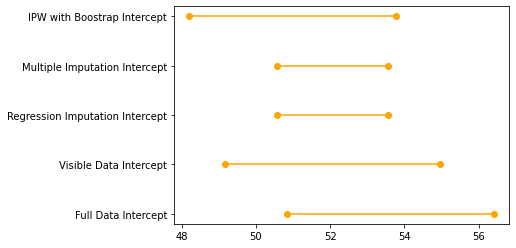

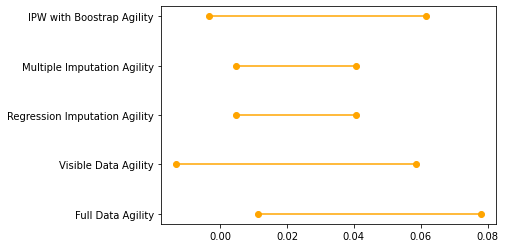

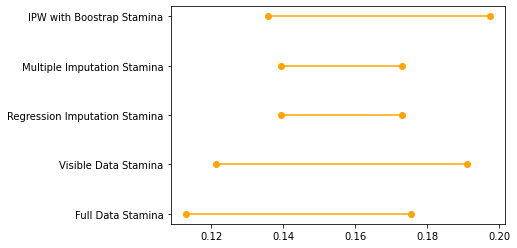

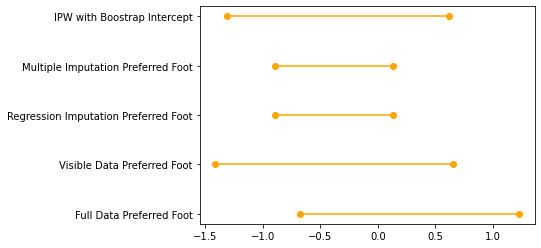

In [89]:
import matplotlib.pyplot as plt
data_dict = {}
names = ['Full Data Intercept', 'Visible Data Intercept', 'Regression Imputation Intercept', 'Multiple Imputation Intercept','IPW with Boostrap Intercept', 'Full Data Agility', 'Visible Data Agility', 'Regression Imputation Agility', 'Multiple Imputation Agility','IPW with Boostrap Agility', 'Full Data Stamina', 'Visible Data Stamina', 'Regression Imputation Stamina', 'Multiple Imputation Stamina','IPW with Boostrap Stamina', 'Full Data Preferred Foot', 'Visible Data Preferred Foot', 'Regression Imputation Preferred Foot', 'Multiple Imputation Preferred Foot','IPW with Boostrap Intercept']
data_dict['lower'] = conf_int_full['Low'][1:] + conf_int_visible['Low'][1:] + conf_int_reg_imp['Low'][1:] + conf_int_mul_imp['Low'][1:] + conf_int_ipw['Low'][1:]
data_dict['upper'] = conf_int_full['High'][1:] + conf_int_visible['High'][1:] + conf_int_reg_imp['High'][1:] + conf_int_mul_imp['High'][1:] + conf_int_ipw['High'][1:]
dataset = pd.DataFrame(data_dict)
y=0
for i in range(4):
    plt.plot((conf_int_full['Low'][i], conf_int_full['High'][i]),(0,0),'ro-',color='orange')
    plt.plot((conf_int_visible['Low'][i], conf_int_visible['High'][i]),(1,1),'ro-',color='orange')
    plt.plot((conf_int_reg_imp['Low'][i], conf_int_reg_imp['High'][i]),(2,2),'ro-',color='orange')
    plt.plot((conf_int_mul_imp['Low'][i], conf_int_mul_imp['High'][i]),(3,3),'ro-',color='orange')
    plt.plot((conf_int_ipw['Low'][i], conf_int_ipw['High'][i]),(4,4),'ro-',color='orange')
    plt.yticks(range(5),names[y:y+5])
    y += 5
    plt.show()

Most of the confidence intervals are fairly close to the original interval, leading us to believe that our choice of explanatory variables is decent and thus, given these variables, our data is MAR.